In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pyqg
from time import time
import os
import glob
from pyqg_generative.models.ols_model import OLSModel
from pyqg_generative.models.mean_var_model import MeanVarModel
from pyqg_generative.models.cgan_regression import CGANRegression
from pyqg_generative.tools.stochastic_pyqg import stochastic_QGModel
from pyqg_generative.tools.spectral_tools import spectrum
from pyqg_generative.tools.comparison_tools import *
import pyqg_parameterization_benchmarks as ppb
from pyqg_generative.tools.operators import Operator1, Operator2, PV_subgrid_forcing
from pyqg_generative.tools.parameters import EDDY_PARAMS
import json
%load_ext autoreload
%autoreload 3

/ext3/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Subgrid forcing at various resolutions

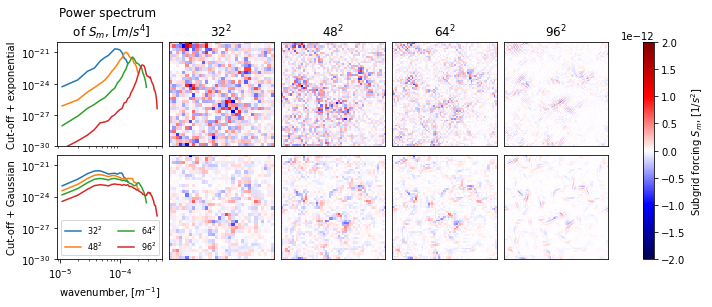

In [328]:
plt.rcParams.update({'font.size': 10})
q = xr.open_dataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/0.nc').q.isel(time=-1)
lev=1
if lev==1:
    ylim = [1e-30, 1e-20]
    vmax=2e-12
else:
    ylim = [1e-27, 1e-17]
    vmax=5e-11
fig, axs = plt.subplots(2,5,figsize=(12.5,4))
plt.subplots_adjust(hspace=0.08, wspace=0)
for j, (resolution, res_name) in enumerate(zip([32, 48, 64, 96], ['$32^2$', '$48^2$', '$64^2$', '$96^2$'])):
    for i, (operator, op_name) in enumerate(zip([Operator1, Operator2], ['cut-off + exponential', 'cut-off + Gaussian'])):
        #qc = operator(q, nc)
        forcing = xr.DataArray(PV_subgrid_forcing(q.values, resolution, operator, EDDY_PARAMS)[0], dims=('lev', 'y', 'x'))
        ax = axs[i][j+1]
        im = ax.imshow(forcing.isel(lev=lev).values, vmin=-vmax, vmax=vmax, cmap='seismic', interpolation='none')
        ax.set_box_aspect(1)
        if i==0:
            ax.set_title(res_name)
        ax.set_xticks([])
        ax.set_yticks([])
        
        sp = spectrum(time=slice(None,None))(forcing.expand_dims('time'))
        axs[i][0].loglog(sp.k, sp.isel(lev=lev).values, label=res_name)
        axs[i][0].set_box_aspect(1)
        
        axs[i][0].set_ylim(ylim)
        if i==1:
            axs[i][0].legend(ncol=2, fontsize=8)
plt.colorbar(im, ax=axs, label='Subgrid forcing $S_m$, [$1/s^2$]')
axs[1][0].set_xlabel('wavenumber, [$m^{-1}$]')
axs[0][0].set_title('Power spectrum \n of $S_m$, [$m/s^4$]')
axs[0][0].set_ylabel('Cut-off + exponential')
axs[1][0].set_ylabel('Cut-off + Gaussian')
axs[0][0].set_xticks([])
plt.savefig('paper_figures/forcing_lower.pdf', bbox_inches='tight', pad_inches=0)

# Convergence of cGAN

In [9]:
stats_none = xr.open_dataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-48/CGANRegression-None/model/stats.nc')
stats_correction = xr.open_dataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-48/CGANRegression/model/stats.nc')
stats_residual = xr.open_dataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-48/CGANRegression-residual/model/stats.nc')

Text(0.5, 1.0, 'Metrics on validation dataset')

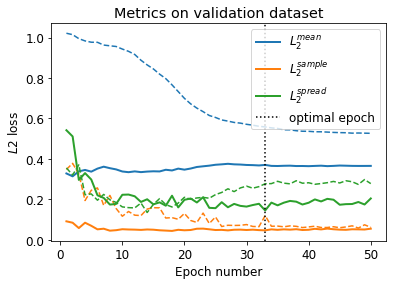

In [10]:
plt.rcParams.update({'font.size': 12})
line = stats_correction.L2_mean_test.plot(lw=2, label='$L_2^{mean}$')
stats_none.L2_mean_test.plot(color=line[0]._color, ls='--')
#stats_residual.L2_mean_test.plot(color=line[0]._color, ls='-.')
line = stats_correction.L2_total_test.plot(lw=2, label='$L_2^{sample}$')
stats_none.L2_total_test.plot(color=line[0]._color, ls='--')
#stats_residual.L2_total_test.plot(color=line[0]._color, ls='-.')
line = stats_correction.L2_residual_test.plot(lw=2, label='$L_2^{spread}$')
stats_none.L2_residual_test.plot(color=line[0]._color, ls='--')
#stats_residual.L2_residual_test.plot(color=line[0]._color, ls='-.')
plt.xlabel('Epoch number')
plt.ylabel('$L2$ loss')
plt.axvline(x=stats_correction.Epoch_opt, ls=':', color='k', label='optimal epoch')
plt.legend()
plt.title('Metrics on validation dataset')
#plt.savefig('paper_figures/training.pdf', bbox_inches='tight', pad_inches=0)

# Metrics across models and resolutions

In [11]:
def L2(type='mean', model='OLSModel', operator='Operator1', resolution=64):
    folder = '/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/'
    file = os.path.join(folder, operator+'-'+str(resolution),model,'offline_test.nc')
    if os.path.exists(file):
        ds = xr.open_dataset(file)
        return float(ds['L2_'+type])
    else:
        print('Wrong path', file)

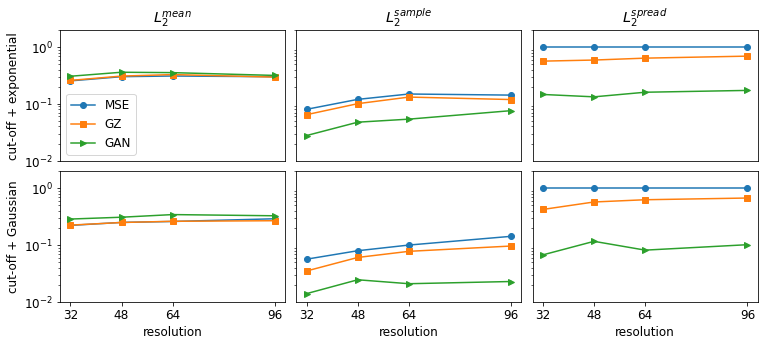

In [12]:
plt.rcParams.update({'font.size': 12})
markers = ['o', 's', '>']
fig, axs = plt.subplots(2,3,figsize=(12.5,5))
plt.subplots_adjust(hspace=0.08, wspace=0.05)
for i, operator in enumerate(['Operator1', 'Operator2']):
    for j, (model, label) in enumerate(zip(['OLSModel', 'MeanVarModel', 'CGANRegression'], ['MSE', 'GZ', 'GAN'])):
        res = [32, 48, 64, 96]
        L2_mean     = [L2('mean', model, operator, resolution) for resolution in res]
        L2_total    = [L2('total', model, operator, resolution) for resolution in res]
        L2_residual = [L2('residual', model, operator, resolution) for resolution in res]
        
        ax = axs[i][0]
        ax.semilogy(res, L2_mean, label=label, marker=markers[j])
        ax.set_ylim([1e-2, 2])
        
        ax = axs[i][1]
        ax.semilogy(res, L2_total, label=label, marker=markers[j])
        ax.set_ylim([1e-2, 2])
        ax.set_yticks([])
        
        ax = axs[i][2]
        ax.semilogy(res, L2_residual, label=label, marker=markers[j])
        ax.set_ylim([1e-2, 2])
        ax.set_yticks([])
        
for j in range(3):
    axs[1][j].set_xlabel('resolution')
    axs[1][j].set_xticks([32, 48, 64, 96])
    axs[0][j].set_xticks([])
axs[0][0].legend()
axs[0][0].set_title('$L_2^{mean}$')
axs[0][1].set_title('$L_2^{sample}$')
axs[0][2].set_title('$L_2^{spread}$')

axs[0][0].set_ylabel('cut-off + exponential')
axs[1][0].set_ylabel('cut-off + Gaussian')

plt.savefig('paper_figures/metrics.pdf', bbox_inches='tight', pad_inches=0)

# Snapshot

In [282]:
def imshow(ax, field, title, vmax, cmap='bwr'):
    if vmax is None:
        vmax = np.percentile(field.values.ravel(), 99.99)
    
    if field.min() < 0:
        vmin = -vmax
    else:
        vmin = 0

    im = ax.imshow(field, vmin=vmin, vmax=vmax, cmap=cmap, interpolation='none')
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
    return im

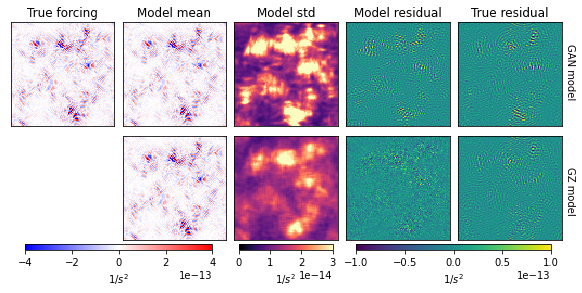

In [333]:
#prms = {'v_total': 8e-13, 'v_std': 2e-14, 'v_residual': 2e-13, 'resolution': 96, 'Operator': 'Operator1', 'lev': 1, 'run': 15, 'time': -1}
#prms = {'v_total': 3e-11, 'v_std': 2e-12, 'v_residual': 3e-11, 'resolution': 64, 'Operator': 'Operator2', 'lev': 0, 'run': 15, 'time': -1}
prms = {'v_total': 4e-13, 'v_std': 3e-14, 'v_residual': 1e-13, 'resolution': 96, 'Operator': 'Operator1', 'lev': 1, 'run': 16, 'time': -1}
#prms = {'v_total': 8e-13, 'v_std': 8e-14, 'v_residual': 2e-13, 'resolution': 64, 'Operator': 'Operator1', 'lev': 1, 'run': 16, 'time': -1}

plt.rcParams.update({'font.size': 10})
fig, axs = plt.subplots(2,5,figsize=(10,4))
plt.subplots_adjust(hspace=0.1, wspace=0.01)
gan = xr.open_dataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/'+prms['Operator']+'-'+str(prms['resolution'])+'/CGANRegression/offline_test.nc').isel(run=prms['run'],time=prms['time'],lev=prms['lev'])
gz = xr.open_dataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/'+prms['Operator']+'-'+str(prms['resolution'])+'/MeanVarModel/offline_test.nc').isel(run=prms['run'],time=prms['time'],lev=prms['lev'])
imshow(axs[0][0], gan.q_forcing_advection, 'True forcing', vmax=prms['v_total'])
art_mean = imshow(axs[0][1], gan.q_forcing_advection_mean, 'Model mean', vmax=prms['v_total'])
art_std  = imshow(axs[0][2], gan.q_forcing_advection_std, 'Model std', vmax=prms['v_std'], cmap='magma')
art_residual = imshow(axs[0][3], gan.q_forcing_advection_gen_res, 'Model residual', vmax=prms['v_residual'], cmap=None)
art_residual = imshow(axs[0][4], gan.q_forcing_advection_res, 'True residual', vmax=prms['v_residual'], cmap=None)

axs[1][0].remove()
imshow(axs[1][1], gz.q_forcing_advection_mean, '', vmax=prms['v_total'])
imshow(axs[1][2], gz.q_forcing_advection_std, '', vmax=prms['v_std'], cmap='magma')
imshow(axs[1][3], gz.q_forcing_advection_gen_res, '', vmax=prms['v_residual'], cmap=None)
imshow(axs[1][4], gz.q_forcing_advection_res, '', vmax=prms['v_residual'], cmap=None)

plt.colorbar(art_mean, cax=fig.add_axes([0.15,0.09,0.26,0.02]), orientation='horizontal', label='$1/s^2$')
plt.colorbar(art_std, cax=fig.add_axes([0.447,0.09,0.13,0.02]), orientation='horizontal', label='$1/s^2$')
plt.colorbar(art_residual, cax=fig.add_axes([0.61,0.09,0.27,0.02]), orientation='horizontal', label='$1/s^2$')
fig.text(0.9,0.62,'GAN model', rotation=-90)
fig.text(0.9,0.22,'GZ model', rotation=-90)

plt.savefig('paper_figures/snapshots.pdf', bbox_inches='tight', pad_inches=0)

# Power spectrum

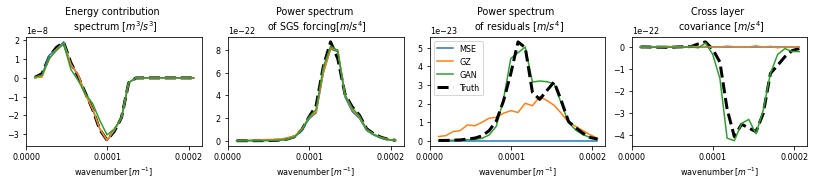

In [272]:
plt.rcParams.update({'font.size': 8})

operator = 'Operator1'
resolution = 48
lev = 1
gan = xr.open_dataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/'+operator+'-'+str(resolution)+'/CGANRegression/offline_test.nc').isel(run=run,lev=lev)
gz = xr.open_dataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/'+operator+'-'+str(resolution)+'/MeanVarModel/offline_test.nc').isel(run=run,lev=lev)
mse = xr.open_dataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/'+operator+'-'+str(resolution)+'/OLSModel/offline_test.nc').isel(run=run,lev=lev)

fig, axs = plt.subplots(1,4,figsize=(14,2))
plt.subplots_adjust(wspace=0.15)


mse.Eflux.plot(ax=axs[0], label='Truth', color='k', ls='--', lw=3)
mse.Eflux_gen.plot(ax=axs[0], label='MSE')
gz.Eflux_gen.plot(ax=axs[0], label='GZ')
gan.Eflux_gen.plot(ax=axs[0], label='GAN')
axs[0].set_title('Energy contribution \n spectrum [$m^3/s^3$]')
axs[0].set_ylabel('')
axs[0].set_xticks([0, 0.0001, 0.0002])
axs[0].set_xlabel('wavenumber [$m^{-1}$]')

mse.PSD.plot(ax=axs[1], label='Truth', color='k', ls='--', lw=3)
mse.PSD_gen.plot(ax=axs[1], label='MSE')
gz.PSD_gen.plot(ax=axs[1], label='GZ')
gan.PSD_gen.plot(ax=axs[1], label='GAN')
axs[1].set_title('Power spectrum \n of SGS forcing[$m/s^4$]')
axs[1].set_ylabel('')
axs[1].set_xticks([0, 0.0001, 0.0002])
axs[1].set_xlabel('wavenumber [$m^{-1}$]')

mse.PSD_gen_res.plot(ax=axs[2], label='MSE')
gz_line = gz.PSD_gen_res.plot(ax=axs[2], label='GZ')
gan_line = gan.PSD_gen_res.plot(ax=axs[2], label='GAN')
#gz.PSD_res.plot(ax=axs[2], ls='--', color=gz_line[0]._color)
gan.PSD_res.plot(ax=axs[2], label='Truth', ls='--', color='k', lw=3)# color=gan_line[0]._color)
axs[2].set_title('Power spectrum \n of residuals [$m/s^4$]')
axs[2].set_ylabel('')
axs[2].set_xticks([0, 0.0001, 0.0002])
axs[2].set_xlabel('wavenumber [$m^{-1}$]')
axs[2].legend()

gan.CSD_res.plot(ax=axs[3], ls='--', color='k', lw=3)
mse.CSD_gen_res.plot(ax=axs[3], label='MSE')
gz.CSD_gen_res.plot(ax=axs[3], label='GZ')
gan.CSD_gen_res.plot(ax=axs[3], label='GAN')
axs[3].set_title('Cross layer \n covariance [$m/s^4$]')
axs[3].set_ylabel('')
axs[3].set_xticks([0, 0.0001, 0.0002])
axs[3].set_xlabel('wavenumber [$m^{-1}$]')

plt.savefig('paper_figures/spectra_offline.pdf', bbox_inches='tight', pad_inches=0)

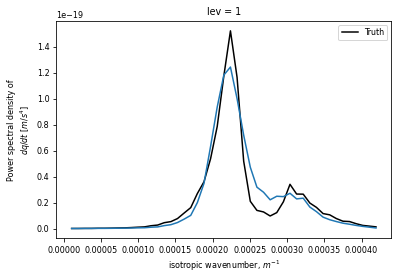

In [296]:
lev=0
xr.open_dataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/'+'Operator1'+'-'+str(96)+'/CGANRegression/offline_test.nc').isel(run=run,lev=lev).PSD_res.plot(label='Truth', color='k')
xr.open_dataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/'+'Operator1'+'-'+str(96)+'/CGANRegression/offline_test.nc').isel(run=run,lev=lev).PSD_gen_res.plot()
plt.legend()